# California Climate Investments Analysis
This notebook includes hierarchical regression, time-series panel analysis, and spatial/PSM models for evaluating collaboration effects in CCI program outcomes.

## 1. Hierarchical Regression

In [2]:
# Hierarchical Regression Analysis
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

df = pd.read_csv('cci_programs_data_reduced.csv' , low_memory=False)
df = df[~df['Reporting Cycle Name'].str.contains('Semi|Mid-Year', na=False)]

df['Total Program GGRFFunding'] = pd.to_numeric(df['Total Program GGRFFunding'], errors='coerce')
df['Total Project GHGReductions'] = pd.to_numeric(df['Total Project GHGReductions'], errors='coerce')
df['Total GGRFDisadvantaged Community Funding'] = pd.to_numeric(df['Total GGRFDisadvantaged Community Funding'], errors='coerce')

df['cost_per_ton'] = df['Total Program GGRFFunding'] / df['Total Project GHGReductions']
df.loc[df['Total Project GHGReductions'] == 0, 'cost_per_ton'] = np.nan
df['share_DAC'] = df['Total GGRFDisadvantaged Community Funding'] / df['Total Program GGRFFunding']

project_counties = df.groupby('Project ID Number')['County'].nunique()
df['n_partners'] = df['Project ID Number'].map(project_counties)
df['multi_county'] = (df['n_partners'] > 1).astype(int)
df['log_funding'] = np.log1p(df['Total Program GGRFFunding'])

south_counties = ["Los Angeles","Orange","San Diego","Riverside","San Bernardino","Imperial","Ventura"]
df['Region_South'] = df['County'].isin(south_counties).astype(int)

df = df.rename(columns={
    'Agency Name': 'Agency_Name',
    'County': 'County'  # keep as is unless renamed too
})


model1 = smf.ols('cost_per_ton ~ log_funding + C(Agency_Name) + C(County)', data=df).fit()
model2 = smf.ols('cost_per_ton ~ log_funding + C(Agency_Name) + C(County) + n_partners + multi_county', data=df).fit()
model3 = smf.ols('cost_per_ton ~ log_funding + C(Agency_Name) + C(County) + n_partners*Region_South', data=df).fit()

print(model3.summary())


                            OLS Regression Results                            
Dep. Variable:           cost_per_ton   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     18.79
Date:                Thu, 10 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:07:08   Log-Likelihood:            -1.2269e+06
No. Observations:              113346   AIC:                         2.454e+06
Df Residuals:                  113130   BIC:                         2.456e+06
Df Model:                         215                                         
Covariance Type:            nonrobust                                         
                                                                                                                                                                                                                  

## 2. Time-Series Panel Regression

Model Coefficients:
 Intercept                                                                            NaN
C(Agency_Collapsed)[T.California Department of Community Services and Development]   NaN
C(Agency_Collapsed)[T.California Department of Food and Agriculture]                 NaN
C(Agency_Collapsed)[T.California Department of Forestry and Fire Protection]         NaN
C(Agency_Collapsed)[T.California Department of Water Resources]                      NaN
C(Agency_Collapsed)[T.Other]                                                         NaN
post_2020                                                                            NaN
log_funding                                                                          NaN
dtype: float64

Robust Std Errors:
 Intercept                                                                            NaN
C(Agency_Collapsed)[T.California Department of Community Services and Development]   NaN
C(Agency_Collapsed)[T.California Department of Food a

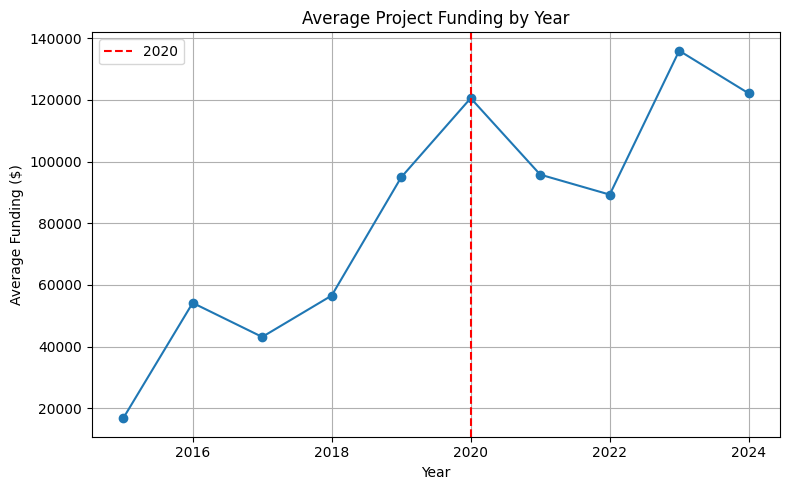

In [9]:
# Time-Series Panel Regression Analysis (Improved)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Load the data
df = pd.read_csv('cci_programs_data_reduced.csv', low_memory=False)

# Clean and rename columns
df = df.rename(columns={
    'Agency Name': 'Agency_Name',
    'County': 'County'
})

# Extract year from reporting cycle string
df['Year'] = df['Reporting Cycle Name'].str.extract(r'(20\d{2})').astype(float)
df['post_2020'] = (df['Year'] >= 2020).astype(int)

# Convert relevant fields to numeric
df['Total Program GGRFFunding'] = pd.to_numeric(df['Total Program GGRFFunding'], errors='coerce')
df['Total Project GHGReductions'] = pd.to_numeric(df['Total Project GHGReductions'], errors='coerce')
df['Total GGRFDisadvantaged Community Funding'] = pd.to_numeric(df['Total GGRFDisadvantaged Community Funding'], errors='coerce')

# Derived outcome variables
df['cost_per_ton'] = df['Total Program GGRFFunding'] / df['Total Project GHGReductions']
df['share_DAC'] = df['Total GGRFDisadvantaged Community Funding'] / df['Total Program GGRFFunding']
df['log_funding'] = np.log1p(df['Total Program GGRFFunding'])

# Collapse agency to top 5 for stability
top_agencies = df['Agency_Name'].value_counts().nlargest(5).index
df['Agency_Collapsed'] = df['Agency_Name'].where(df['Agency_Name'].isin(top_agencies), 'Other')

# Drop rows with missing values in required fields
model_df = df[['cost_per_ton', 'log_funding', 'Agency_Collapsed', 'Year', 'post_2020']].dropna()

# Fit the model (simplified with reduced categorical levels)
panel_model = smf.ols('cost_per_ton ~ post_2020 + log_funding + C(Agency_Collapsed)', data=model_df).fit(cov_type='HC3')

# Output coefficients and robust standard errors
print("Model Coefficients:\n", panel_model.params)
print("\nRobust Std Errors:\n", panel_model.bse)

# Annual summary stats
annual_stats = df.groupby('Year').agg(
    avg_funding=('Total Program GGRFFunding', 'mean'),
    median_cost_per_ton=('cost_per_ton', 'median'),
    avg_share_DAC=('share_DAC', 'mean'),
    project_count=('Project ID Number', 'nunique')
).dropna()

# Plot: Average project funding over time
plt.figure(figsize=(8, 5))
plt.plot(annual_stats.index, annual_stats['avg_funding'], marker='o')
plt.axvline(2020, color='red', linestyle='--', label='2020')
plt.title('Average Project Funding by Year')
plt.xlabel('Year')
plt.ylabel('Average Funding ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
# Check how many rows are left in the model
print("Rows in model_df:", len(model_df))

# Check for any missing values
print("Missing values per column:\n", model_df.isna().sum())

# Look at the variance in the outcome
print("Variance in cost_per_ton:", model_df['cost_per_ton'].var())
print("Unique cost_per_ton values:", model_df['cost_per_ton'].nunique())

# Check number of categories
print("Agency_Collapsed categories:", model_df['Agency_Collapsed'].unique())


Rows in model_df: 145335
Missing values per column:
 cost_per_ton        0
log_funding         0
Agency_Collapsed    0
Year                0
post_2020           0
dtype: int64
Variance in cost_per_ton: nan
Unique cost_per_ton values: 25361
Agency_Collapsed categories: ['California Air Resources Board' 'Other'
 'California Department of Food and Agriculture'
 'California Department of Forestry and Fire Protection'
 'California Department of Community Services and Development'
 'California Department of Water Resources']


/Users/dpadams/Repos/new_california_equity/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [11]:
df = df[df['Total Project GHGReductions'] > 0].copy()  # filter out 0 or missing reductions
df['cost_per_ton'] = df['Total Program GGRFFunding'] / df['Total Project GHGReductions']


In [12]:
model_df = df[['cost_per_ton', 'log_funding', 'Agency_Collapsed', 'Year', 'post_2020']].dropna()
print("Rows in model_df (filtered):", len(model_df))
print("Variance in cost_per_ton:", model_df['cost_per_ton'].var())


Rows in model_df (filtered): 135433
Variance in cost_per_ton: 132987112.40001555


In [13]:
panel_model = smf.ols('cost_per_ton ~ post_2020 + log_funding + C(Agency_Collapsed)', data=model_df).fit(cov_type='HC3')
print(panel_model.summary())


                            OLS Regression Results                            
Dep. Variable:           cost_per_ton   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     142.5
Date:                Thu, 10 Apr 2025   Prob (F-statistic):          2.31e-210
Time:                        11:15:08   Log-Likelihood:            -1.4578e+06
No. Observations:              135433   AIC:                         2.916e+06
Df Residuals:                  135425   BIC:                         2.916e+06
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                                                                                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

## 3. Spatial Analysis and Propensity Score Matching

In [21]:
# Spatial Analysis and Propensity Score Matching
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load and clean data
df = pd.read_csv('cci_programs_data_reduced.csv')
df = df.rename(columns={'Agency Name': 'Agency_Name', 'County': 'County'})

# Convert numeric columns
df['Total Program GGRFFunding'] = pd.to_numeric(df['Total Program GGRFFunding'], errors='coerce')
df['Total Project GHGReductions'] = pd.to_numeric(df['Total Project GHGReductions'], errors='coerce')
df['Total GGRFDisadvantaged Community Funding'] = pd.to_numeric(df['Total GGRFDisadvantaged Community Funding'], errors='coerce')

# Calculate variables
df['cost_per_ton'] = df['Total Program GGRFFunding'] / df['Total Project GHGReductions']
df['share_DAC'] = df['Total GGRFDisadvantaged Community Funding'] / df['Total Program GGRFFunding']
df['log_funding'] = np.log1p(df['Total Program GGRFFunding'])

# Aggregate to project level
project_df = df.groupby('Project ID Number').agg({
    'log_funding': 'first',
    'Agency_Name': 'first',
    'County': 'first',
    'cost_per_ton': 'first',
    'share_DAC': 'first'
}).reset_index()

# Add collaboration and region
project_df['n_partners'] = df.groupby('Project ID Number')['County'].nunique().values
project_df['high_collab'] = (project_df['n_partners'] > 5).astype(int)

south_counties = ["Los Angeles", "Orange", "San Diego", "Riverside", "San Bernardino", "Imperial", "Ventura"]
project_df['Region_South'] = project_df['County'].isin(south_counties).astype(int)

# Drop any remaining NA rows before modeling
project_df = project_df.dropna(subset=['log_funding', 'Agency_Name', 'Region_South', 'high_collab'])

# Prepare covariates
covariates = ['log_funding', 'Agency_Name', 'Region_South']
X = pd.get_dummies(project_df[covariates], drop_first=True)

# Fix any object dtypes and ensure all numeric
X = X.astype(float)

# Dependent variable: ensure binary and numeric
y = project_df['high_collab'].astype(int)

# Confirm dtypes before modeling
print("X dtypes:\n", X.dtypes.value_counts())
print("y dtype:", y.dtype)

# Fit the model
ps_model = sm.Logit(y, sm.add_constant(X)).fit(disp=0)
project_df['propensity'] = ps_model.predict(sm.add_constant(X))


# Propensity score model
ps_model = sm.Logit(y, sm.add_constant(X)).fit(disp=0)
project_df['propensity'] = ps_model.predict(sm.add_constant(X))

# Nearest neighbor matching
treated = project_df[project_df['high_collab'] == 1]
control = project_df[project_df['high_collab'] == 0]

matches = []
for idx, p in treated['propensity'].items():
    closest_idx = (control['propensity'] - p).abs().idxmin()
    matches.append((idx, closest_idx))

matched_idx = [i for pair in matches for i in pair]
matched_sample = project_df.loc[matched_idx]

# Compare outcomes
# Clean extreme values
matched_sample = matched_sample.replace([np.inf, -np.inf], np.nan).dropna(subset=['cost_per_ton', 'share_DAC'])

matched_treated = matched_sample[matched_sample['high_collab'] == 1]
matched_control = matched_sample[matched_sample['high_collab'] == 0]

print("High-collab avg $/ton:", matched_treated['cost_per_ton'].mean())
print("Low-collab avg $/ton:", matched_control['cost_per_ton'].mean())
print("High-collab avg share_DAC:", matched_treated['share_DAC'].mean())
print("Low-collab avg share_DAC:", matched_control['share_DAC'].mean())



X dtypes:
 float64    22
Name: count, dtype: int64
y dtype: int64
High-collab avg $/ton: 544.4898966105618
Low-collab avg $/ton: 382.8083520549755
High-collab avg share_DAC: 0.7419354838709677
Low-collab avg share_DAC: 0.6


/var/folders/5d/5d9bb60d0jxbnghwm5jp9xy00000gp/T/ipykernel_62779/3350860769.py:7: DtypeWarning: Columns (1,13,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cci_programs_data_reduced.csv')
/Users/dpadams/Repos/new_california_equity/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/dpadams/Repos/new_california_equity/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
